# Data preprocessing

Run this code in AAI3 environment

In [ ]:
import os
from mtcnn import MTCNN
from mtcnn.utils.images import load_image
import json
import pandas as pd

In [2]:
def get_file_list(root_dir):

    file_list = []
    extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
    for root, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))

    return file_list

In [3]:
root_dir = r"/home/atvars/School/advanced_ai/session3"
filenames = get_file_list(root_dir)

# Applying the MTCNN to the dataset.
---

Run this code in AAI3 environment

In [5]:
detector = MTCNN(device='gpu')

I0000 00:00:1740590395.933538  576131 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3933 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
mtcnn_detections = []
for image in filenames:
    img = load_image(image)
    mtcnn_detections.append(detector.detect_faces(img))

I0000 00:00:1740590398.515829  576131 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [28]:
with open('just_box_detections.csv' , 'w') as f:
    for i in range(len(mtcnn_detections)):
        for j in range(len(mtcnn_detections[i])):
            f.write(json.dumps(mtcnn_detections[i][j]['box']) + ';' + filenames[i] +'\n')

# Preprocessing for FaceNet
---

Run in AAI3_2

In [ ]:
import skimage
from skimage.transform import resize
import pandas as pd
import ast
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from PIL import Image
import re
import os
import numpy as np
from keras.models import load_model


from sklearn.preprocessing import LabelEncoder

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

import random
%matplotlib inline

Read the boxes, and image paths

In [ ]:
temp_df = pd.read_csv('just_box_detections.csv', sep=';', header=None)
temp_df.columns = ['boxes', 'filename']

In [ ]:
# List in the DF is a string, so we need to convert it to a list
temp_df['boxes'] = temp_df['boxes'].apply(ast.literal_eval)

In [7]:
temp_df.head()

,boxes,filename
0,"[74, 64, 78, 107]",/home/atvars/School/advanced_ai/session3/Data/...
1,"[50, 42, 35, 46]",/home/atvars/School/advanced_ai/session3/Data/...
2,"[59, 38, 85, 122]",/home/atvars/School/advanced_ai/session3/Data/...
3,"[71, 51, 86, 120]",/home/atvars/School/advanced_ai/session3/Data/...
4,"[68, 21, 90, 124]",/home/atvars/School/advanced_ai/session3/Data/...


In [8]:
boxes, filenames = temp_df['boxes'], temp_df['filename']

Box = [x, y, width, height]

#### Testing image with bounding box

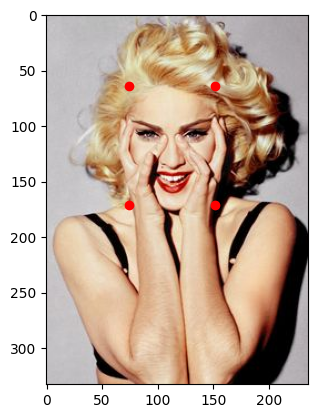

In [13]:
image = imread(filenames[0])
plt.imshow(image)
plt.plot(boxes[0][0], boxes[0][1], 'ro')
plt.plot(boxes[0][0] + boxes[0][2], boxes[0][1] + boxes[0][3], 'ro')
plt.plot(boxes[0][0], boxes[0][1] + boxes[0][3], 'ro')
plt.plot(boxes[0][0] + boxes[0][2], boxes[0][1], 'ro')
plt.show()

### Extracting faces from images

Cropping code from [here](https://stackoverflow.com/questions/6456479/python-pil-how-to-save-cropped-image)

In [ ]:
output_dir = "Processed_Data"
os.makedirs(output_dir, exist_ok=True)

'''
Later, I get the target values by reading the image path, and extracting the parent directory name.

Processed_Data
|__train
|  |__madonna
|  |  |first_image_of_madonna_from_train_set.jpg
|__val
|  |__madonna
|  |  |first_image_of_madonna_from_test_set.jpg

And so on...
'''

for idx, (path, box) in enumerate(zip(temp_df["filename"], temp_df["boxes"])):
    # Extract train/val and class name from path
    parts = path.split("/")
    dataset_type = parts[-3]  # 'train' or 'val'
    class_name = parts[-2]  # e.g., 'madonna'

    # Create output directory structure
    class_dir = os.path.join(output_dir, dataset_type, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Open and process image
    img = Image.open(path).convert("RGB")
    img = img.crop((box[0], box[1], box[0] + box[2], box[1] + box[3]))
    img = img.resize((160, 160))

    # Generate unique filename
    base_filename = os.path.basename(path)
    filename, ext = os.path.splitext(base_filename)
    new_filename = f"{filename}_{idx}{ext}"  # Ensures uniqueness

    # Save cropped face
    img.save(os.path.join(class_dir, new_filename))


### Reading Faces + Scaling

In [33]:
train_path = "/home/atvars/School/advanced_ai/session3/Processed_Data/train"
val_path = "/home/atvars/School/advanced_ai/session3/Processed_Data/val"

In [97]:
X_train = []
X_test = []

for path in os.listdir(train_path):
    for deeper_path in os.listdir(os.path.join(train_path, path)):
        img = imread(os.path.join(train_path, path, deeper_path))
        img = (img - img.mean()) / img.std()
        X_train.append(img)

for path in os.listdir(val_path):
    for deeper_path in os.listdir(os.path.join(val_path, path)):
        img = imread(os.path.join(val_path, path, deeper_path))
        img = (img - img.mean()) / img.std()
        X_test.append(img)

X_train = np.array(X_train)
X_test = np.array(X_test)

In [98]:
print(X_train.shape)
print(X_test.shape)


(97, 160, 160, 3)
(28, 160, 160, 3)


## Predicting via FaceNet
---

In [ ]:
model = load_model("/home/atvars/School/advanced_ai/session3/keras-facenet/model/facenet_keras.h5")

model.load_weights("/home/atvars/School/advanced_ai/session3/keras-facenet/weights/facenet_keras_weights.h5")

In [ ]:
train_preds = []
for image in X_train:
    image = np.expand_dims(image, axis=0)
    train_preds.append(model.predict(image))

In [ ]:
val_preds = []
for image in X_test:
    image = np.expand_dims(image, axis=0)
    val_preds.append(model.predict(image))

## Training SVM
---

### Getting y

In [ ]:
dataset_path = "Processed_Data/train"

y_train, y_val = [], []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-directory files

    for filename in os.listdir(class_path):
        y_train.append(class_name)  # Label based on folder name

dataset_path = "Processed_Data/val"

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-directory files

    for filename in os.listdir(class_path):
        y_val.append(class_name)  # Label based on folder name

y_train = np.array(y_train)
y_val = np.array(y_val)

# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

### Training Classifier

In [52]:
train_preds = np.array(train_preds)
val_preds = np.array(val_preds)

train_preds = train_preds.reshape(train_preds.shape[0], train_preds.shape[2])
val_preds = val_preds.reshape(val_preds.shape[0], val_preds.shape[2])

scaler = StandardScaler()
train_preds = scaler.fit_transform(train_preds)
val_preds = scaler.transform(val_preds)

In [54]:
classifier = SVC(kernel='linear', probability=True)
classifier.fit(train_preds, y_train)


SVC(kernel='linear', probability=True)

# Classifier Evaluation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediction: Ben Afflek\nConfidence: 0.91')

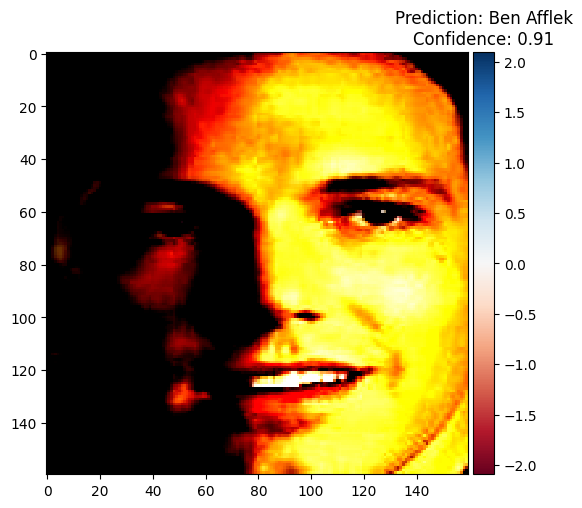

In [93]:
possible_people = ['Ben Afflek', 'Elton John', 'Jerry Seinfeld', 'Madonna', 'Mindy Kaling']

# Generate random ID, so the image is different every time the cell is executed
id = random.randint(0, len(val_preds)-1)
# Plot the image (Skimage is gonna complain because the image is normalized with StandardScaler)
imshow(X_test[id])
# Predict the person
pred = classifier.predict(val_preds[id].reshape(1, -1))
# Predict the confidence of the prediction
plt.title(f"Prediction: {possible_people[pred[0]]}\nConfidence: {classifier.predict_proba(val_preds[id].reshape(1, -1)).max().round(2)}")

In [55]:
print(f"Mean Accuracy on Training Set: {classifier.score(train_preds, y_train)}")
print(f"Mean Accuracy on Validation Set: {classifier.score(val_preds, y_val)}")

Mean Accuracy on Training Set: 1.0
Mean Accuracy on Validation Set: 0.9285714285714286
